### Fraud  Detection in Mobile  Payment  Transactions  

Notebook with EDA and Predictive ML for  fraud identification. This  is  valuable in financial institutions e.g. in banking, mobile payment and  insurance  sectors. The data  is a synthetic one and  is  generated using the simulator called PaySim. Paysim simulated mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country.  The dataset is scaled down 1/4 of the original dataset. 

#### Acknowledgements
This work is part of the research project ”Scalable resource-efficient systems for big data analytics” funded
by the Knowledge Foundation (grant: 20140032) in Sweden.

References:

E. A. Lopez-Rojas , A. Elmir, and S. Axelsson. "PaySim: A financial mobile money simulator for fraud detection". In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus. 2016


In [4]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [157]:
fraud_data = pd.read_csv('PS_20174392719_1491204439457_log.csv') ##dataset 

In [7]:
fraud_data.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


A little  bit of  EDA at this point. Made use of sweetviz https://pypi.org/project/sweetviz/. This library provides a summary of  most EDA tasks plus  associations in entities

In [8]:
#pip install sweetviz 

In [9]:
import sweetviz as sv
#analyzing the dataset
fraud_report = sv.analyze(fraud_data) #Takes sometime  but  will work.
#display the report
fraud_report.show_html('Fraud_report.html')  ## The report is  saved in the root folder of this notebook 

:FEATURES DONE:                    |                     | [  0%]   02:07  -> (00:00 left)
:PAIRWISE DONE:                    |█████████████████████| [100%]   01:45  -> (00:00 left)


Creating Associations graph... DONE!


In [13]:
#check for  any null values 
fraud_data.isnull().any() #None seem to exist

step              False
type              False
amount            False
nameOrig          False
oldbalanceOrg     False
newbalanceOrig    False
nameDest          False
oldbalanceDest    False
newbalanceDest    False
isFraud           False
isFlaggedFraud    False
dtype: bool

From the dataset, the column "newbalanceOrig" will be renamed to "newbalanceOrg" for  consistency with "oldbalanceOrg". 


In [14]:
fraud_data.rename(columns={'newbalanceOrig':'newbalanceOrg'},inplace=True)

Drop 'nameOrig' and 'nameDest' columns. They are names that dont add any value to the modelling. Categorical data makes more sense to the modelling process.

In [15]:
fraud_data.drop(labels=['nameOrig','nameDest'],axis=1,inplace=True)

### Fraud in Transactions 

#### 1. All transaction types

In [25]:
fraud_data.type.unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

#### 2. Transaction types with fraudlent  transactions  

In [24]:
print(fraud_data.loc[fraud_data.isFraud == 1].type.drop_duplicates().values)

['TRANSFER' 'CASH_OUT']


Only two of the five  transaction types had a fraudlent transaction flagged

#### 3. Number of  transactions  under ['TRANSFER' 'CASH_OUT']   transactions  

In [30]:
Fraud_data_Transfer = fraud_data.loc[(fraud_data.isFraud == 1) & (fraud_data.type == 'TRANSFER')]
Fraud_data_Cashout = fraud_data.loc[(fraud_data.isFraud == 1) & (fraud_data.type == 'CASH_OUT')]

In [38]:
print("There were: ",len(Fraud_data_Transfer), "fraudlent  activities in 'TRANSFER' type transactions\n ")
print("There were: ",  len(Fraud_data_Cashout), "fraudlent  activities  in 'CASH_OUT' type transactions")

There were:  4097 fraudlent  activities in 'TRANSFER' type transactions
 
There were:  4116 fraudlent  activities  in 'CASH_OUT' type transactions


This  means  that we'll spend longer in 'TRANSFER' and 'CASH_OUT' types of transactions as fraud is only recorded here. 

### Some  More Data Analysis

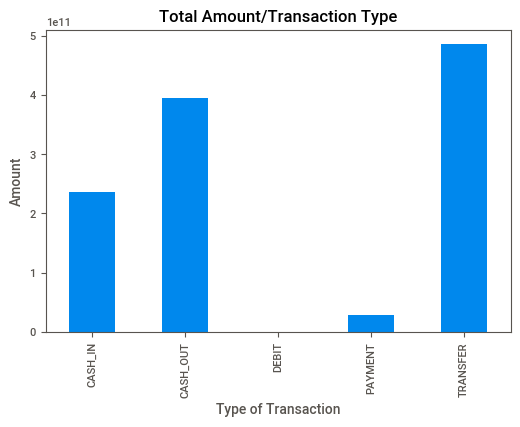

In [40]:
x = fraud_data.groupby('type').amount.sum()
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
x.plot(kind='bar')
ax1.set_title("Total Amount/Transaction Type")
ax1.set_xlabel('Type of Transaction')
ax1.set_ylabel('Amount');

Ideally, 'TRANSFER' is  where money is sent to a customer/fraudster.  For 'CASH_OUT', money is  sent  to a merchant or someone who cashes it  out for the  fraudster.  From the plot above, the number of fraudulent TRANSFERs almost equals the number of fraudulent CASH_OUTs. This  mirrors the description of the  dataset where fraud is committed by first transferring out funds to another account which subsequently cashes it out. This  explains why 'TRANSFER' and 'CASH_OUT' transactions make up the bulk of fraudlent  transactions.

### Correlations  between  variables 

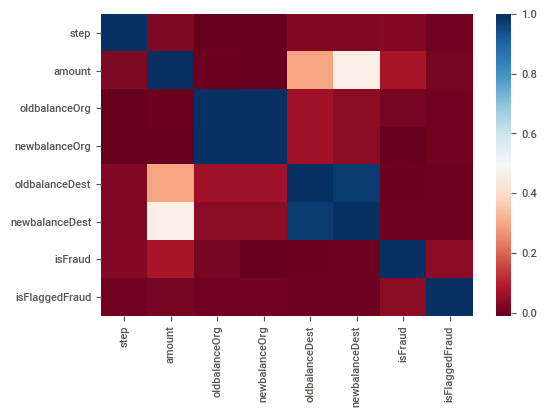

In [42]:
import seaborn as sb
sb.heatmap(fraud_data.corr(),cmap='RdBu');

We can draw the below conclusions from the heatmap:-
    1. NewbalanceOrg and OldbalanceOrg correlate highly.
    2. NewbalanceDest and OldbalanceDest also highly correlate.

Not  much can be deduced  except for  some  correlation in the  amount  and NewbalanceDest and OldbalanceDest


In [60]:
print('Transaction type where FlaggedFraud is set: \
{}'.format(list(fraud_data.loc[fraud_data.isFlaggedFraud == 1].type.drop_duplicates()))) 

Transaction type where FlaggedFraud is set: ['TRANSFER']


In [62]:
fraud_data_Transfer = fraud_data.loc[fraud_data.type == 'TRANSFER']
fraud_data_Flagged = fraud_data.loc[fraud_data.isFlaggedFraud == 1] #Flagged by the system
fraud_data_NotFlagged = fraud_data.loc[fraud_data.isFlaggedFraud == 0]

In [63]:
print('Minimum amount transacted when transaction is set to isFlaggedFraud: {}'.format(fraud_data_Flagged.amount.min()))

print('\nMaximum amount transacted in a TRANSFER where isFlaggedFraud is not set=\
 {}'.format(fraud_data_Transfer.loc[fraud_data_Transfer.isFlaggedFraud == 0].amount.max()))

Minimum amount transacted when transaction is set to isFlaggedFraud: 353874.22

Max amount transacted in a TRANSFER where isFlaggedFraud is not set= 92445516.64


### Determination of why isFlaggedFraud is set. Any tangible proof?
#### Can oldBalanceDest and newBalanceDest  be used to determine this?


In [73]:
print('Minimum and Maximum of oldBalanceOrig for isFlaggedFraud=1 TRANSFERs: {}'.\
format([round(fraud_data_Flagged.oldbalanceOrg.min()), round(fraud_data_Flagged.oldbalanceOrg.max())]))

print('\nMinimu and  Maximum of oldBalanceOrig for isFlaggedFraud=0 TRANSFERs where oldBalanceOrig  = newBalanceOrig: {}'.format(\
[fraud_data_Transfer.loc[(fraud_data_Transfer.isFlaggedFraud == 0) & (fraud_data_Transfer.oldbalanceOrg \
== fraud_data_Transfer.newbalanceOrg)].oldbalanceOrg.min(), \
round(fraud_data_Transfer.loc[(fraud_data_Transfer.isFlaggedFraud == 0) & (fraud_data_Transfer.oldbalanceOrg \
               == fraud_data_Transfer.newbalanceOrg)].oldbalanceOrg.max())]))

Minimum and Maximum of oldBalanceOrig for isFlaggedFraud=1 TRANSFERs: [353874.0, 19585040.0]

Minimu and  Maximum of oldBalanceOrig for isFlaggedFraud=0 TRANSFERs where oldBalanceOrig  = newBalanceOrig: [0.0, 575668.0]


In [70]:
fraud_data_Flagged.head()

,step,type,amount,oldbalanceOrg,newbalanceOrg,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,4953893.08,4953893.08,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,1343002.08,1343002.08,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,536624.41,536624.41,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,4892193.09,4892193.09,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,19585040.37,19585040.37,0.0,0.0,1,1


#### Look at the  fraudlent and  non-fraud related transaction.


In [43]:
fraudlent  = fraud_data.loc[fraud_data.isFraud == 1]
nonfraudlent = fraud_data.loc[fraud_data.isFraud == 0]

In [75]:
print ("There are",len(fraudlent),"fraudlent transactions") #8213 fraudlent  transactions 

There are 8213 fraudlent transactions


In [47]:
len(nonfraudlent)

6354407

Heavily skewed dataset making it  hard for say a rule based model to predict accurately

#### Correlation plot for variables in the fraudlent subset

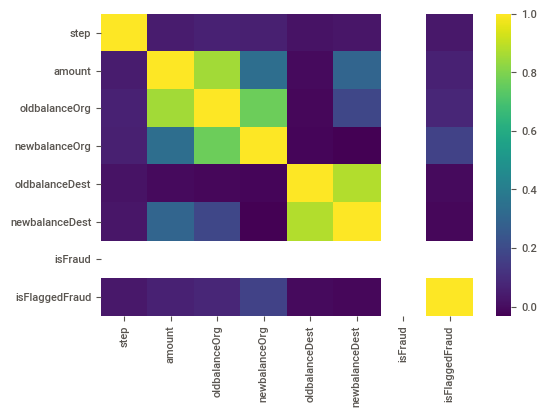

In [54]:
sns.heatmap(fraudlent.corr(),cmap='viridis',);

From the  above plot heatmap, "isFlaggedFraud" doesn't  seem to correlate  to any other factor in the dataset. How  the flagging was done is  not  so clear thsu can be  dropped from the modelling aspect.

In [68]:
print('Total number of fraud transactions is {}.'.format(fraud_data.isFraud.sum()))
print('Total number of fraud transaction and is marked as fraud is {}.'.format(fraud_data.isFlaggedFraud.sum()))
print('Fraud transaction vs non-fraud transaction  ratio is 1:{}.'.format(int(len(nonfraudlent)/len(fraudlent))))
print('Total amount lost in fraudlent  transactions is  ${}.'.format(int(fraudlent.amount.sum())))

Total number of fraud transactions is 8213.
Total number of fraud transaction and is marked as fraud is 16.
Fraud transaction vs non-fraud transaction  ratio is 1:773.
Total amount lost in fraudlent  transactions is  $12056415427.


Ideally, for every fraudlent  transaction there are 773 other non-fraudlent  transactions. $12056415427  is not a small amount.

In [80]:
pie_plot = fraudlent.groupby(['isFlaggedFraud']).sum()

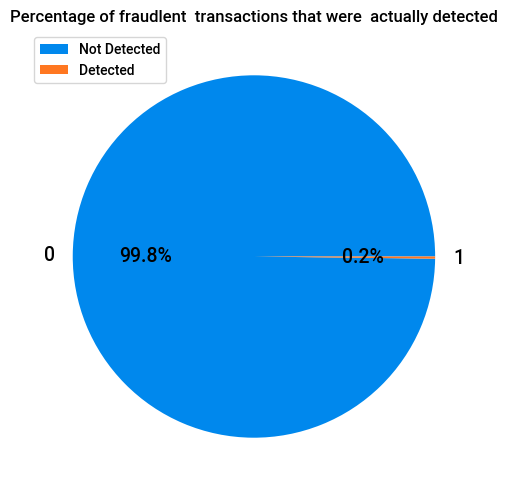

In [81]:
f, axes = plt.subplots(1,1, figsize=(8,6))
axes.set_title("Percentage of fraudlent  transactions that were  actually detected")
pie_plot.plot(kind='pie',y='isFraud',ax=axes, fontsize=14,shadow=False,autopct='%1.1f%%');
axes.set_ylabel('');
plt.legend(loc='upper left',labels=['Not Detected','Detected'])
plt.show()

### Data Modelling and Prediction 

In [83]:
import pickle

A subset of the data  i.e. with TRANSFER and  CASH_OUT recorded fraudlent  transaction. Therefore, no need to focus on other transactions 

In [84]:
X = fraud_data.loc[(fraud_data.type == 'TRANSFER') | (fraud_data.type == 'CASH_OUT')] #

In [85]:
X.head()

,step,type,amount,oldbalanceOrg,newbalanceOrg,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,181.0,0.0,0.0,0.00,1,0
3,1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1,0
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0,0
19,1,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0,0
24,1,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0,0


In [86]:
len(X) #2770409 are of  interest in the modelling  process

2770409

In [87]:
Y = X['isFraud']
del X['isFraud']


In [106]:
Y.head()

2     1
3     1
15    0
19    0
24    0
Name: isFraud, dtype: int64

isFlaggedFraud proved irrelevant  in the analysis. Nothing  on its correlation with other variables

In [107]:
X = X.drop(['isFlaggedFraud'], axis = 1) 

####  Encode 'type' variable with labels for easier modelling. 

In [108]:
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)

C:\Users\wanda\.conda\envs\deepml37\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [109]:
X.head() # All types encoded as expected

,step,type,amount,oldbalanceOrg,newbalanceOrg,oldbalanceDest,newbalanceDest
2,1,0,181.00,181.0,0.0,0.0,0.00
3,1,1,181.00,181.0,0.0,21182.0,0.00
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44
19,1,0,215310.30,705.0,0.0,22425.0,0.00
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89


### Dealing with Skewness in the dataset
The  dataset is  quite  imbalanced. Skewed data, more so the ratio of available records and the  number of  fraudlent transactions.

In [116]:
print('Skew in the data is about = {}'.format( len(Xfraud) / float(len(X))*100 ),'%') 

Skew in the data is about = 0.2964544224336551 %


Dealing  with unbalanced datasets is a bit  tricky based on the balancing  technique to be deployed. A few tricks  come to mind:-

1. Discarding the majority class  before modelling (undersampling) - Entails  discarding a huge chunk of the majority class. However, this means  the model will not perform well in a real test environment.
2. Oversampling of the minority class -  Techniques such as SMOTE contained in the 'imblearn' library come to mind. 

ML algorithms  based on decision trees perform well on imbalanced datasets or those with say missing values. I'll try two of  them i.e. extreme gradient-boosted (XGBoost) algorithm and random-forest.  


Area under the precision-recall curve (AUPRC) metric  works  better for  such skewed  datasets compared to say ROC. This is because the AUPRC is more sensitive to differences between algorithms and their parameter settings rather than the AUROC (see Davis and Goadrich, 2006).

In [137]:
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split, learning_curve


Split the dataset  into training and test sets in an  80:20 ratio

In [136]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, random_state = 42) #random state  help in getting consistent results 

### Extreme Gradient-Boosted (XGBoost) Algorithm 

In [154]:
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 10, scale_pos_weight = weights, n_jobs = 10)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('Area Under the Precision-Recall Curve (AUPRC) - XGBoost= {}'.format(average_precision_score(testY,probabilities[:, 1])))

Area Under the Precision-Recall Curve (AUPRC) - XGBoost= 0.9811590796563867


### Random Forest Classifier 

In [142]:
clf_rf = RandomForestClassifier(n_estimators=20)
probabilities_rf = clf_rf.fit(trainX, trainY).predict_proba(testX)
print('Area Under the Precision-Recall Curve (AUPRC) - Random Forest Classifier = {}'.format(average_precision_score(testY,probabilities_rf[:, 1])))

Area Under the Precision-Recall Curve (AUPRC) - Random Forest Classifier = 0.9141322345864418


In [144]:
len(probabilities_rf)

554082

#### Important  variables in the XGBoost Model 

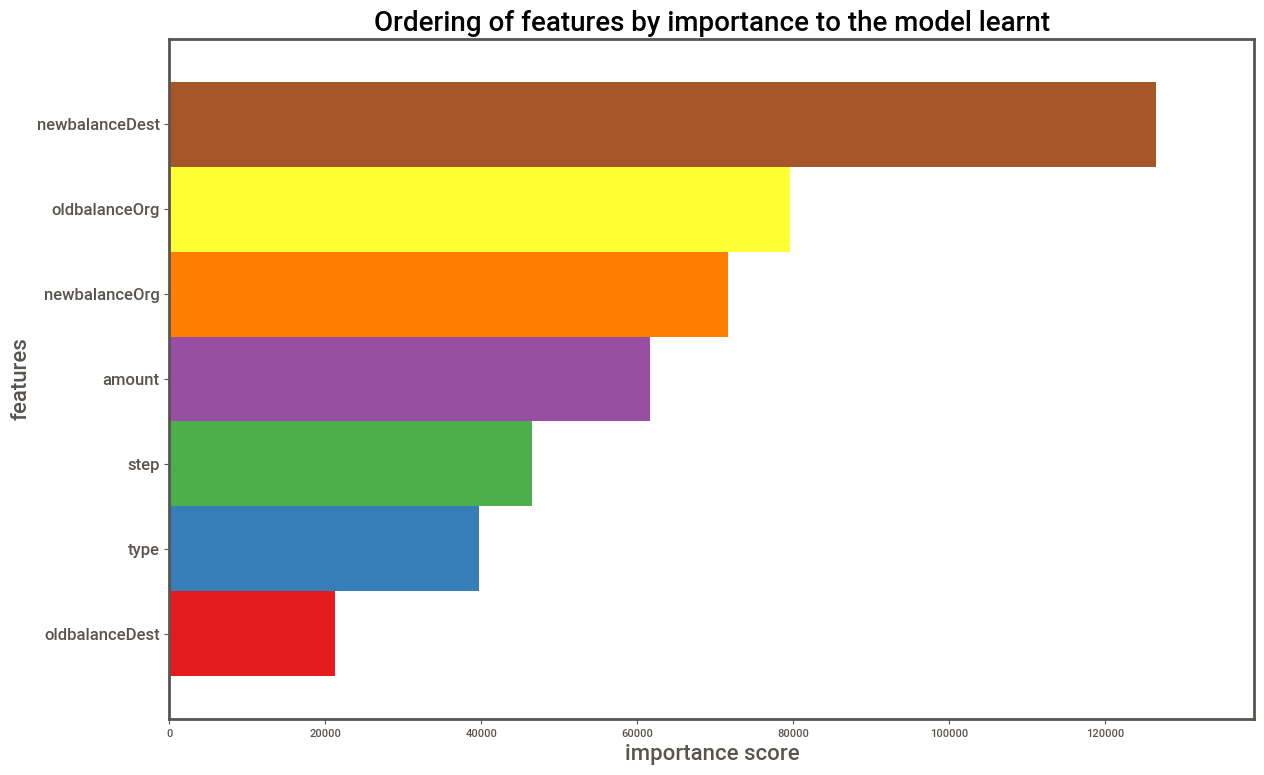

In [145]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)
colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

#### Important variables in RandomForest Classifier 

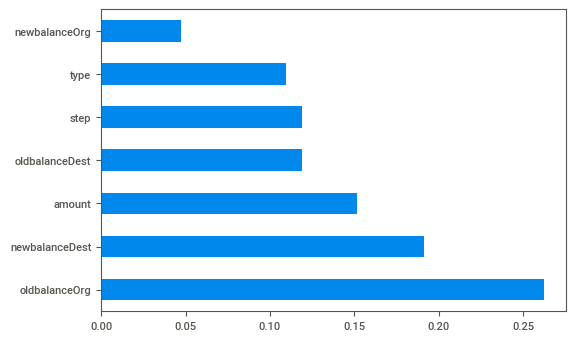

In [156]:
feat_importances = pd.Series(clf_rf.feature_importances_, index=trainX.columns)
feat_importances.nlargest(7).plot(kind='barh')

#### Conclusions  
1. Fraud  detection is a difficult  process. This  is especially compounded by the lack of integral data in the area. In the above example, a large amount  of transactions marked as likely to be  fraud, were actually not. In addition, there  seems to be  no rules in flagging  transactions as fraudlent. 
2. Tree based  algorithms  worked better in detection of fraud. This is partly attributed to the nature of  data. 